In [2]:
%pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy


Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from nltk import word_tokenize          
import pandas as pd
import math

sys.path.append('../utils/')
from gpt_tokenize import gpt_tokenize

sys.path.append('..')
from preprocessing import load_dataframes
from constant import CATEGORIES
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from utils.gpt_tokenize import normalize2_text
import tiktoken


In [2]:
(df_train, df_val, df_test) = load_dataframes()




In [39]:
df_train.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall_toxic
140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0,1
159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0,0
60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0,0
65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0,0
154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0,0


In [41]:
# Séparation du DataFrame en deux sous-ensembles selon la valeur de la colonne "overall_toxic"
df_toxic = df_train[df_train['overall_toxic'] == 1]
df_non_toxic = df_train[df_train['overall_toxic'] == 0]

# Détermination du nombre minimum de lignes dans chaque classe
min_samples = min(len(df_toxic), len(df_non_toxic))

# Échantillonnage d'un nombre égal de lignes dans chaque classe
df_toxic_sampled = df_toxic.sample(n=min_samples, replace=True, random_state=42)
df_non_toxic_sampled = df_non_toxic.sample(n=min_samples, replace=True, random_state=42)

# Concaténation des deux sous-ensembles échantillonnés
df_balanced = pd.concat([df_toxic_sampled, df_non_toxic_sampled], ignore_index=True)

# Mélange des lignes pour mélanger les classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_balanced
# Affichage des informations sur le nouveau DataFrame équilibré
print("Nombre de lignes avec overall_toxic=1 :", len(df_train[df_train['overall_toxic'] == 1]))
print("Nombre de lignes avec overall_toxic=0 :", len(df_train[df_train['overall_toxic'] == 0]))


Nombre de lignes avec overall_toxic=1 : 12981
Nombre de lignes avec overall_toxic=0 : 12981


In [10]:
tokens = gpt_tokenize(df_train)


In [4]:
print(tokens[:100])


[53766, 1764, 2024, 462, 8395, 23701, 83777, 2024, 462, 23701, 662, 12491, 83777, 2024, 462, 662, 282, 1034, 1034, 597, 15123, 758, 220, 6028, 13, 5728, 13, 4767, 13, 1272, 1174, 220, 24, 1253, 220, 1049, 24, 320, 70696, 883, 1053, 30689, 17113, 4562, 6532, 2700, 773, 36554, 60891, 1174, 1053, 16686, 25670, 3508, 3766, 2759, 320, 1841, 2353, 11164, 87099, 1695, 3335, 883, 1053, 4148, 11334, 79, 39936, 3896, 40815, 662, 12895, 551, 1080, 72, 11810, 1274, 4600, 4652, 1174, 10030, 73, 5472, 1174, 3152, 16994, 23391, 5905, 1203, 51944, 2660, 869, 62411, 662, 220, 508, 25, 1682, 10103]


In [11]:
enc = tiktoken.encoding_for_model("gpt-4")
tokens_list = [(enc.decode([word])) for word in tokens]



In [9]:
print(tokens_list[:100])
enc.decode([53766])


['grand', 'ma', ' ter', 'ri', ' burn', ' trash', ' grandma', ' ter', 'ri', ' trash', ' .', ' hate', ' grandma', ' ter', 'ri', ' .', ' f', ' %', ' %', ' k', ' hell', ' !', ' ', '71', '.', '74', '.', '76', '.', '40', ' ,', ' ', '9', ' may', ' ', '200', '9', ' (', ' utc', ' )', ' would', ' easiest', ' admit', ' member', ' involved', ' port', 'ug', 'uese', ' lodge', ' ,', ' would', ' requirement', ' acknowledge', ' whether', ' previous', ' account', ' (', ' car', 'los', ' bot', 'elho', ' good', ' record', ' )', ' would', ' remove', ' sock', 'p', 'uppet', ' template', ' irrelevant', ' .', ' wp', ' :', ' co', 'i', ' permit', ' people', ' edit', ' article', ' ,', ' ms', 'j', 'apan', ' ,', ' mean', ' careful', ' ensuring', ' reference', ' back', ' edits', ' np', 'ov', ' upheld', ' .', ' ', '20', ':', '29', ' ``']


'grand'

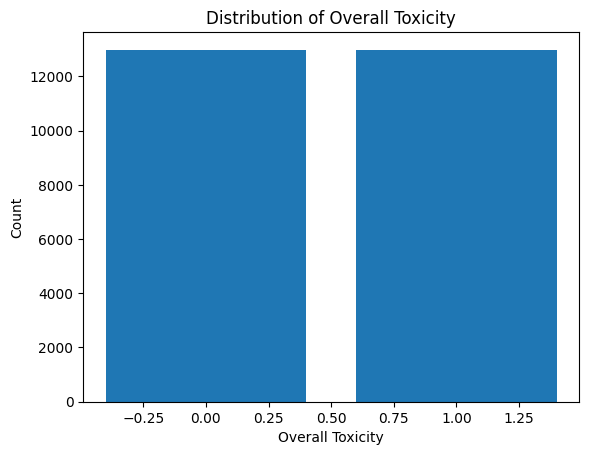

In [42]:
train_df = df_train
total_user_input = len(train_df)
toxicity_1 = len(train_df[train_df['overall_toxic'] == 1])
toxicity_0 = len(train_df[train_df['overall_toxic'] == 0])

table = pd.DataFrame({'Total User Input': [total_user_input], 'Toxicity 1': [toxicity_1], 'Toxicity 0': [toxicity_0]})
table

# Count the number of occurrences of each category
toxic_counts = train_df['overall_toxic'].value_counts()

# Create a bar plot
plt.bar(toxic_counts.index, toxic_counts.values)

# Add labels and title
plt.xlabel('Overall Toxicity')
plt.ylabel('Count')
plt.title('Distribution of Overall Toxicity')

# Show the plot
plt.show()



In [6]:
df_train.describe()


,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall_toxic
count,127656.000000,127656.00000,127656.000000,127656.000000,127656.000000,127656.000000,127656.000000
mean,0.095867,0.00998,0.052751,0.003165,0.049062,0.008703,0.101687
std,0.294410,0.09940,0.223537,0.056167,0.215997,0.092884,0.302238
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
X = df_train['comment_text']
y = df_train['overall_toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) #ne semble pas necessaire car il y a qu'une seul classe possible
#model = make_pipeline(CountVectorizer(ngram_range = (1,1)), MultinomialNB())
# Etape 1 : Calcul de la fréquence des mots
vectorizer = CountVectorizer(tokenizer=gpt_tokenize)
X_train_counts = vectorizer.fit_transform(X_train)
# Etape 2 : Sélection des stop words
word_freq = X_train_counts.sum(axis=0)  # Somme des fréquences pour chaque terme
words = vectorizer.get_feature_names_out()
freqs = zip(words, word_freq.A1)  # A1 convertit une matrice 1D en array numpy
sorted_words = sorted(freqs, key=lambda x: x[1], reverse=True)

n_stop_words = 15  # ou 10, selon votre choix
stop_words = [word for word, freq in sorted_words[:n_stop_words]]

# Etape 3 : Filtrage des stop words et entraînement du modèle
vectorizer_with_stop_words_filter = CountVectorizer(stop_words=stop_words)
model = make_pipeline(vectorizer_with_stop_words_filter, MultinomialNB())
X_train_counts = vectorizer.fit_transform(X_train)
#model = make_pipeline(   CountVectorizer(tokenizer=normalize2_text, ngram_range=(1,1),stop_words=list(en_stop)),MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


/Users/jasonperez/.pyenv/versions/3.11.8/envs/bigdata/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [54]:
#print(vectorizer.vocabulary_)
#len(vectorizer.vocabulary_)
print(stop_words)
#print(vectorizer_with_stop_words_filter.vocabulary_["and"])``
#print(vectorizer.vocabulary_["656"])
# lignes_contenant_naruto = X_train[1246]
# lignes_contenant_naruto



[' .', ' ,', ' !', " ''", " '", ' ', ' ``', ' ?', ' n', '.', ' )', ' :', ' (', 's', "'t"]


In [55]:
print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Features dimension: (20769, 46849)
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      2575
           1       0.90      0.87      0.88      2618

    accuracy                           0.88      5193
   macro avg       0.88      0.88      0.88      5193
weighted avg       0.88      0.88      0.88      5193



## Plot confusion matrix

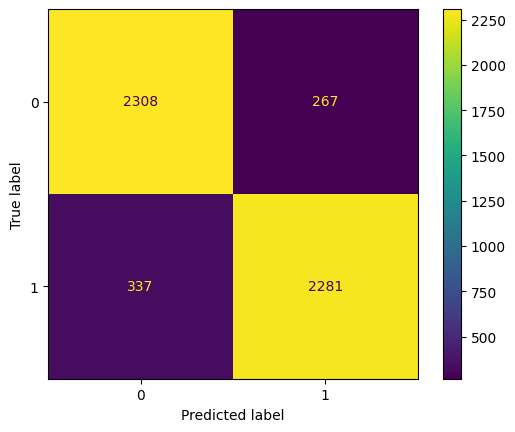

In [56]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()


## Cross validation



In [57]:
# Perform cross-validation and print the mean accuracy
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")


Mean f1_macro: 0.8882372736169826
Standard deviation f1_macro: 0.004286039374459819


In [17]:
#y_train.head()

#X_train.head()


51730     .  And that would verify that John was a Pratt...
104007    hi how are you  are you Mr bill \n\naoa \n    ...
93525                            Abi 17:45, 9 February 2014
157886    We can agree on one thing: the numbers do spea...
153252    I noticed that on the media page there are onl...
Name: comment_text, dtype: object

### Calculate priors and vocabulary

In [58]:
count_c = Counter(y_train)

priors = {k:v/len(y_train) for k, v in count_c.items()}
print(priors)
words = list(vectorizer_with_stop_words_filter.vocabulary_.keys())
train_strings = " ".join(words)
train_tokens = word_tokenize(train_strings)
vocabulary = set(train_tokens)
V = len(vocabulary)
classes = set(y_train)


{1: 0.4989648033126294, 0: 0.5010351966873706}


In [59]:
print(vocabulary)
len(vocabulary)


{'upstate', 'susteren', 'review', 'ash', 'docboat', 'patriotic', 'consumerist', 's1038', 'lune', 'upon', 'chenism', 'artical', 'nbsp', 'onassis', 'monthes', 'capuchin', 'insanity', 'pescadores', 'tindersticks', 'dwpaul', 'imports', 'hinshaw', 'perfecto', 'eio', 'ack', 'npower', 'broadening', 'unmolested', 'peternity', 'arn', 'schiavo', 'fez', 'eighty', 'sentences', 'perk', '979', 'houdova', 'fetal', '287', 'halvard', 'uuuuuu', 'pressurization', 'kung', 'civilisation', 'whipping', 'iva', 'midavalo', 'leaps', 'shhh', 'dieted', 'hostility', 'festival', 'manyak', 'policymakers', 'altemose', 'maniacs', 'organizer', 'psychiatry', 'samson', 'unverifiable', 'sympathizer', 'emporis', 'stalwart', 'factoring', 'wordings', 'nirmal', 'naming', 'enaidmawr', 'dances', 'cultivate', 'stockpiled', 'reorganising', 'rehnquist', 'impatience', 'morphs', 'moo', 'kannangara', 'nableezy', 'interprets', 'preidency', 'rode', 'athiesm', 'fruitlessly', 'notibility', 'sbs6272t5', 'dysfunction', 'miremare', 'tasc0',

46845

In [60]:
print(classes)


{0, 1}


### Calculate likelihoods


In [61]:
train_df = pd.DataFrame(zip(X_train, y_train), columns = ["comment_text", "overall_toxic"])
train_df = pd.DataFrame(train_df)
train_df


,comment_text,overall_toxic
0,"THIS IS AWFUL, JUST AWFUL!!! ALL GERMANS ARE M...",1
1,Anal leakage ban hammer?,1
2,"Fuck you, you cunt. Don't ever fucking accuse...",1
3,"Hey Sue, How are u. from u know who\n\nHey Sue...",0
4,You're being a first-class dick. Focus on how...,1
...,...,...
20764,Masturbating with custard? \n\nI heard it was ...,1
20765,"I propose that you sir, are an unconscienable ...",1
20766,Email \n\nI have noted the email sent. '''' (H2O),0
20767,How dare you yank\n\nThe english language stat...,0


In [62]:
mega_dict = dict() 
prob_dict = dict()
k = 1

for c in classes:
    class_df = df_train[df_train["overall_toxic"] == c]
    mega_document = class_df["comment_text"]
    mega_strings = " ".join(mega_document)
    mega_tokens = word_tokenize(mega_strings)
    mega_count = Counter(mega_tokens)
    mega_dict[c] = mega_count
    prob_dict[c] = dict()
    for token in vocabulary:
        prob_dict[c][token] = (mega_dict[c][token] + k ) / (len(mega_tokens) + V)


In [199]:
print(mega_dict[1]["patrick"]) # ici on verifie le nombre de fois où "eithan" est présent dans les phrases non toxic (0)
print(prob_dict[0]["love"]) # ici on verifie la prob par rapport au token et a la toxicité cf cours formule


0
0.00012457023269719466


### Prediction

In [194]:
test_tokens = word_tokenize("chretian attack")
test_tokens = [token for token in test_tokens if token in vocabulary]

pred_dict = dict()

for c in classes:
    sum = math.log2(priors[c])
    for token in test_tokens:
        #print(prob_dict[c][token])
        sum += math.log2(prob_dict[c][token])
    sum = math.pow(2, sum)
    pred_dict[c] = sum
print(pred_dict)
print(max(pred_dict, key=pred_dict.get))


{0: 9.139203259550169e-05, 1: 0.00016841224891003044}
1


In [20]:
test_tokens = [word_tokenize(text) for text in X_test]

pred_dict = dict()
preds = list()

for report_tokens in test_tokens:
    for c in classes:
        suma = math.log2(priors[c])
        for token in report_tokens:
            if token in prob_dict[c]: # remove unknown tokens
                suma += math.log2(prob_dict[c][token])
        suma = math.pow(2, suma)
        pred_dict[c] = suma
    preds.append(max(pred_dict, key=pred_dict.get))


In [21]:
print(classification_report(preds, list(y_test)))


              precision    recall  f1-score   support

           0       0.86      0.79      0.82        62
           1       0.80      0.87      0.83        61

    accuracy                           0.83       123
   macro avg       0.83      0.83      0.83       123
weighted avg       0.83      0.83      0.83       123



In [22]:
def train_model():
    (df_train, df_val, df_test) = load_dataframes2()
    X = df_train['user_input']
    y = df_train['toxicity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = CountVectorizer()
    X_train_counts = vectorizer.fit_transform(X_train)
    # Etape 2 : Sélection des stop words
    word_freq = X_train_counts.sum(axis=0)  # Somme des fréquences pour chaque terme
    words = vectorizer.get_feature_names_out()
    freqs = zip(words, word_freq.A1)  # A1 convertit une matrice 1D en array numpy
    sorted_words = sorted(freqs, key=lambda x: x[1], reverse=True)

    n_stop_words = 10  # ou 10, selon votre choix
    stop_words = [word for word, freq in sorted_words[:n_stop_words]]

    # Etape 3 : Filtrage des stop words et entraînement du modèle
    # SI ON VEUT NORMALIZER LES TEXTES
    #vectorizer_with_stop_words_filter = CountVectorizer(stop_words=stop_words,tokenizer=normalize2_text)
    vectorizer_with_stop_words_filter = CountVectorizer(stop_words=stop_words)
    model = make_pipeline(vectorizer_with_stop_words_filter, MultinomialNB())
    X_train_counts = vectorizer.fit_transform(X_train)
    #model = make_pipeline(   CountVectorizer(tokenizer=normalize2_text, ngram_range=(1,1),stop_words=list(en_stop)),MultinomialNB())
    model.fit(X_train, y_train)

    #Priors
    count_c = Counter(y_train)
    #priors = {k:v/len(y_train) for k, v in count_c.items()}
    words = list(vectorizer_with_stop_words_filter.vocabulary_.keys())
    train_strings = " ".join(words)
    train_tokens = word_tokenize(train_strings)
    vocabulary = set(train_tokens)
    classes = set(y_train)

    #LikeLihoods
    mega_dict = dict()
    prob_dict = dict()
    k = 1

    for c in classes:
        class_df = df_train[df_train["toxicity"] == c]
        mega_document = class_df["user_input"]
        mega_strings = " ".join(mega_document)
        mega_tokens = word_tokenize(mega_strings)
        mega_count = Counter(mega_tokens)
        mega_dict[c] = mega_count
        prob_dict[c] = dict()
        for token in vocabulary:
            prob_dict[c][token] = (mega_dict[c][token] + k ) / (len(mega_tokens) + V)
    


In [26]:
def isToxicity(test_tokens):
    #test_tokens = normalize2_text(test_tokens)
    test_tokens = word_tokenize(test_tokens)
    test_tokens = [token for token in test_tokens if token in vocabulary]

    pred_dict = dict()

    for c in classes:
        sum = math.log2(priors[c])
        for token in test_tokens:
            #print(prob_dict[c][token])
            sum += math.log2(prob_dict[c][token])
        sum = math.pow(2, sum)
        pred_dict[c] = sum
    print(pred_dict)
    print(max(pred_dict, key=pred_dict.get))
    


In [24]:
train_model()


In [31]:
isToxicity("fuck your mom")


{0: 4.766452307891641e-12, 1: 9.108166321203191e-12}
1


### EITHAN

In [59]:


vectorizer = CountVectorizer()


X_train = vectorizer.fit_transform(df_train['user_input']).toarray()
X_valid = vectorizer.transform(df_val['user_input']).toarray()
X_test = vectorizer.transform(df_test['user_input']).toarray()

y_train = df_train['toxicity']
y_valid = df_val['toxicity']
y_test = df_test['toxicity']


In [15]:
train_model()


2922    0
2354    0
977     1
4129    0
3404    0
       ..
1514    0
3475    0
517     0
2505    0
2619    0
Name: toxicity, Length: 1017, dtype: int64


#### Model Binary Classification

In [10]:
model_binary_label = GaussianNB()
model_binary_label.fit(X_train, y_train)
model_binary_label.score(X_valid, y_valid)


0.7856440511307768

In [11]:
model_binary_label.score(X_test, y_test)


0.7672634271099744

#### Model Multilabel Classification 